In [81]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 05
### Team Member Names: James Begin, Jonathan Wen, Emily Qi
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


# Introduction 
The goal of the market "meet" portfolio is to match the returns of the average of the TSX60 and S&P500 indices as closely as possibly. To do this, we look at various indicators that can provide insight into a stock's ability to match market returns. Below are the factors we plan to take into account while constructing our portfolio:  
- Volume
- Price
- Market Cap
- EJJ (Emily, Jonathan, James) Score (Pronounced like "edge")
- Earnings and Dividend Dates  

## Filtering
First, we ignore any delisted stocks, or non-US and Canadian Stocks, then filter by average monthly volume, minimum price, and market cap:
  



In [82]:
tickers = pd.read_csv('Tickers.csv')
#remove any whitespace for each ticker
tickerlist = [tickers.columns[0].strip()]
tickerlist += [i.strip() for i in tickers.iloc[:,0]]
#remove duplicates from the list
tickerlist = list(dict.fromkeys(tickerlist))

#for our analysis, use the year of 2024
startdate = '2024-01-01'
enddate = datetime.now().strftime('%Y-%m-%d')

stockdata = yf.download(tickerlist, start=startdate, end=enddate)
#remove any delisted tickers
delisted = list(yf.shared._ERRORS.keys())
for i in delisted:
    tickerlist.remove(i)
    
exchangelist = ['NMS', 'NYQ', 'TOR']
minprice = 5
minvolume = 100000
mincap = 1000000000

#remove any tickers that dont satisfy our filter requirements
for ticker in tickerlist:
    t = yf.Ticker(ticker)
    hist = t.history(start=startdate, end=enddate, period='1mo')
    inf = t.fast_info
    if ((t.get_history_metadata())['exchangeName'] not in exchangelist
            or hist['Volume'].mean() < minvolume 
            or hist['Close'].mean() < minprice
            or inf['market_cap'] < mincap):
        tickerlist.remove(ticker)    

[*********************100%***********************]  41 of 41 completed

4 Failed downloads:
['MON', 'AGN', 'CELG', 'RTN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


## Earnings Dates and Dividends
The period surrounding Earnings Dates, and Dividend Dates typically bring about higher volatility as investors and speculators buy and sell, hoping to take advantage of upcoming news and guidance. Below we illustrate some of the effects of Earnings/Corporate Announcements on volatility.


<BarContainer object of 2 artists>

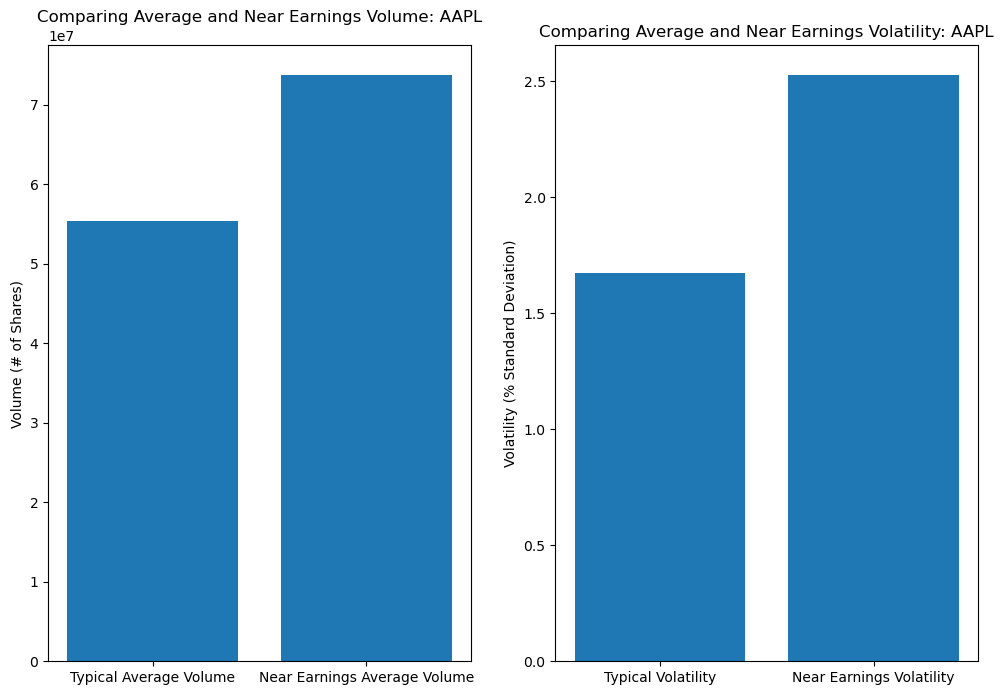

In [83]:
start1='2024-07-10'
end1='2024-07-24'
start2='2024-04-24'
end2='2024-05-06'
voldata = stockdata.loc[:, 'Volume']
plot1 = voldata.loc[start1:end1, 'AAPL'].mean()
plot2 = voldata.loc[start2:end2, 'AAPL'].mean()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 8)
ax1.set_title("Comparing Average and Near Earnings Volume: AAPL")
ax1.set_ylabel('Volume (# of Shares)')
ax1.bar(['Typical Average Volume', 'Near Earnings Average Volume'], [plot1, plot2])

plot3 = stockdata.loc[:, 'Adj Close'].loc[start1:end1, 'AAPL'].pct_change().std() * 100
plot4 = stockdata.loc[:, 'Adj Close'].loc[start2:end2, 'AAPL'].pct_change().std() * 100
ax2.set_title("Comparing Average and Near Earnings Volatility: AAPL")
ax2.set_ylabel("Volatility (% Standard Deviation)")
ax2.bar(['Typical Volatility', 'Near Earnings Volatility'], [plot3, plot4])

Notice the significant increase in both volume and volatility when AAPL is near earnings. This is what we want to avoid.

Considering that we want to minimize volatility in order to meet the market, we filter out any stocks that have upcoming earnings or dividend dates:

In [84]:
#fetch the current and cutoff dates
currdate = (datetime.now()).date()
cutoff = (currdate + timedelta(days=14))

for ticker in tickerlist:
    #fetch the relevant dates
    cal = yf.Ticker(ticker).calendar
    #ensure that the yfinance has the dates we want
    div = (cal['Ex-Dividend Date'] if 'Ex-Dividend Date' in cal.keys() else cutoff)
    earnings = (cal['Earnings Date'][1] if len(cal['Earnings Date']) > 1 else cal['Earnings Date'][0])
    #check if there are events in the near future
    if ((earnings > currdate) and (cutoff > earnings)) or ((div > currdate) and (cutoff > div)):
        tickerlist.remove(ticker)
        

## EJJ Score
Beta is a measure of volatility of a security or portfolio compared to the market. A beta of 1.0 indicates that a stock follows the market's returns exactly. We can take the average of the two indices and calculate the beta for each stock. However, Beta is only a measure of how sensitive a stock's returns are compared to the market. We could have a stock with beta close to 1.0, but with a low correlation, which is not what we are after. Considering we want to match the market's returns exactly, we use correlation to identify the strength of a relationship with an index.  
  
We calculate the rolling correlation with each stock to the market average, as this ensures we capture how the correlation might have changed over past (especially in recent months). Then, we find both the average correlation and standard deviation of the correlation. Using this, we identify how often the stock is highly correlated (over a certain correlation threshold). The result of this metric is a percentage.  
  
Then, we calculate how stable the correlation is for each stock. This is done by dividing the average correlation by the standard deviation of the correlation. This ensures that we also take into account, not only high correlation, but high correlation that doesn't change often.  
  
To calculate the final score, we find the reciprocal of the distance of each beta to 1.0 (this ensures that bigger values are always better) and multiply it by the percent of time the stock is highly correlated. and by how stable the correlation is.  

  
We can calculate beta using the formula (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [96]:
indices = pd.DataFrame()
indices['tsxprice'] = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close']
indices['spprice'] = yf.download('SPY', start=startdate, end=enddate)['Adj Close']

closedata = stockdata.loc[:, 'Adj Close']

indices.index = indices.index.tz_localize(None) 
closedata.index = closedata.index.tz_localize(None)

tsxpct = indices['tsxprice'].pct_change(fill_method=None)
sppct = indices['spprice'].pct_change(fill_method=None)
avgpct = (tsxpct + sppct) / 2
tsxvar = tsxpct.var()
spvar = sppct.var()
avgvar = (tsxvar + spvar) / 2
scores = {}

#calculate score for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    common = closedata[ticker].index.intersection(indices.index)
    
    closepct = closedata.loc[common, ticker].pct_change(fill_method=None)
    
    #calculate beta with respect to TSX and S&P Average
    beta = closepct.cov(avgpct) / avgvar
    
    #print(beta)
    #calculate weekly rolling correlation (7 day window)
    rolling_correlation = closepct.rolling(window=14).corr(sppct)
    correlation_std = rolling_correlation.std()
    correlation_mean = rolling_correlation.mean()
    #find how often each stock is strongly correlated
    correlation_pct = (rolling_correlation > 0.5).mean()
    #find how consistent the correlation is
    consistency = correlation_mean / (correlation_std if correlation_std != 0 else 0.0001)
    #calculate score
    
    #print(ticker, 1 / (1 + abs(beta-1.0)), correlation_mean, correlation_pct, consistency)
    score = correlation_pct * (1 / (1 + abs(beta - 1.0))) * consistency
    
    scores[ticker] = abs(score)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Date
2024-01-02         NaN
2024-01-03   -0.004710
2024-01-04   -0.000513
2024-01-05    0.002093
2024-01-08    0.010258
                ...   
2024-11-18    0.002970
2024-11-19    0.002222
2024-11-20    0.000169
2024-11-21    0.009902
2024-11-22    0.002986
Length: 227, dtype: float64


The highest score stocks are: 
AMZN 3.05030061793
AAPL 1.4934407135948584
CAT 1.4265661711061104
C 1.2959970603404665
TXN 1.1755209375558853
AXP 1.022073360517881
USB 0.8750578852526082
RY.TO 0.5603898280773618
ACN 0.5204612363006828
AIG 0.514664893670038
BK 0.49569873997473035
SHOP.TO 0.4833901726215316
UNP 0.37961458690030353
PYPL 0.3513198732868696
UPS 0.23719464990220443
BIIB 0.20635904913679684
LLY 0.18626669006746072
BA 0.141100961545617
PFE 0.04851492607627653
MRK 0.030802451446579206
ABBV 0.029917516539195083
ABT 0.029165722373619696
T.TO 0.016913930340056196
UNH 0.013848880124418554
PM 0.011462775093728679
MO 0.00730691928663995
BMY 0.005398818918734805
CL 0.0028713089953916224
PG 6.877276430664594e-05


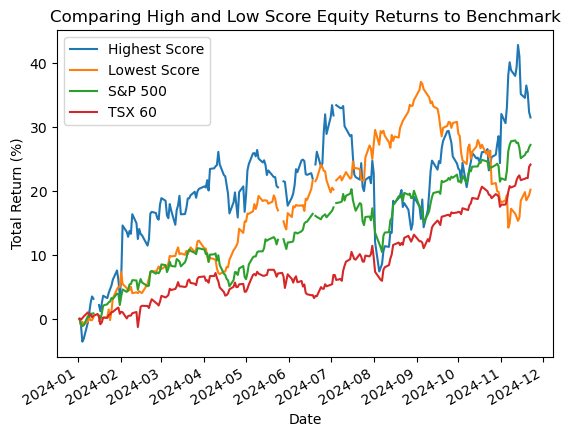

In [93]:
scores_sorted = []
print('The highest score stocks are: ')
for t in sorted(scores, key=scores.get, reverse=True):
    scores_sorted.append(t)
    print(t, scores[t])

fig, ax = plt.subplots()
ax.set_title("Comparing High and Low Score Equity Returns to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Total Return (%)")


ax.plot(closedata[scores_sorted[0]] / (closedata[scores_sorted[0]]).values[0] * 100 - 100, label='Highest Score')
ax.plot(closedata[scores_sorted[-2]] / (closedata[scores_sorted[-2]]).values[0] * 100 - 100, label='Lowest Score')
ax.plot(indices['spprice'] / indices['spprice'].values[0] * 100 - 100, label='S&P 500')
ax.plot(indices['tsxprice'] / indices['tsxprice'].values[0] * 100 - 100, label='TSX 60')
fig.autofmt_xdate()
ax.legend(loc='best')

plt.show()


This plot aims to show the effectiveness of our score in finding "market matching" stocks. Notice, that just by observation, the highest score returns match both of the indices much better than the lowest score stock.

## Making the Portfolio
Next, in order to decide on the number of stocks in our portfolio, there are two main factors to consider:

1. Limiting non-market risk
2. Using stocks with the highest scores possible

Firstly, if market risk occurs during the contest period, it would not only affect the specific stocks we selected but the market indices as well. Thus, we will focus on limiting diversifiable risk instead. To do this, we should try to maximize the number of different stocks we include in our portfolio so that if individual companies face issues during the week, any impacts on the overall portfolio value are minimized. 

However, since we ordered the stocks in order of score from highest to lowest, we prefer companies higher up on the list versus ones lower down. Thus, we also need to keep in consideration that the more stocks we choose to include, the lower the scores we will have in our portfolio, thus affecting its correlation with the market index.

As a solution, we will choose a compromise - 16 stocks. This still provides us with some diversification benefits to limit non-market risk (especially compared to only choosing to add 12 stocks) while allowing us to target stocks with higher scores (compared to taking the top 24 off our list).

### Weightings
Since our list of stocks is ordered from highest to lowest score, we will give the stocks with higher scores a greater weight (but still less than the maximum permitted) in our portfolio. This is so that the stocks with lower scores still contribute to our portfolio's diversification (with weights slightly greater than the minimum permitted), but their lower correlation with market indices won't make the overall portfolio deviate significantly away from our target values. To achieve this, we will use numpy's linspace function to generate equally spaced weightings for each stock within the minimum and maximum weight bounds.

In [94]:
#determine the weightings, number of shares, currencies, and values of our stocks
num_stocks = 16
#generate equally spaced weights for each of our 16 stocks
weights = np.linspace(9, 3.5, num_stocks)
totalc = 1000000

Portfolio_Final = pd.DataFrame()
Portfolio_Final['Ticker'] = scores_sorted[:num_stocks]
Portfolio_Final['Weight'] = weights
pricelist = []
sharelist = []
currlist = []
valuelist = []
#get usdcad exchange rate
usdcad = yf.Ticker("USDCAD=X").history(period='1d', start='2024-11-18', end='2024-11-23')['Close'].iloc[0]

for ticker in range(num_stocks):
    
    cash = weights[ticker]*totalc
    t = yf.Ticker(scores_sorted[ticker])
    p = (closedata.loc[:, scores_sorted[ticker]]).values[-1]

    pricelist.append(p)
    
    #if the stock is listed in USD, 
    if (t.get_history_metadata())['exchangeName'] != 'TOR':
        currlist.append('USD')
        cadp = p * usdcad
        num_shares = cash / cadp
        if 0.001 * num_shares < 3.95:
            cadp += 0.001
            num_shares = cash/cadp
            sharelist.append(num_shares)
            value = num_shares * cadp - 0.001
        else:
            num_shares = (cash-3.95)/cadp
            sharelist.append(num_shares)
            value = num_shares * cadp
    else:
        currlist.append('CAD')
        num_shares = cash / p

        if 0.001 * num_shares < 3.95:
            p += 0.001
            num_shares = cash/p
            sharelist.append(num_shares)
            value = num_shares * (p-0.001)
        else:
            num_shares = (cash-3.95)/p
            sharelist.append(num_shares)
            value = num_shares * p
    
    
    valuelist.append(value)

Portfolio_Final['Price'] = pricelist
Portfolio_Final['Shares'] = sharelist
Portfolio_Final['Value'] = valuelist
Portfolio_Final['Currency'] = currlist
Portfolio_Final.index = Portfolio_Final.index + 1 #make indices start at 1
print(f"Total Portfolio Value: ${Portfolio_Final['Value'].sum()}")
print(f"Total Portfolio Weight: {Portfolio_Final['Weight'].sum()}")

Total Portfolio Value: $99999936.8
Total Portfolio Weight: 100.0


In [88]:
Portfolio_Final

,Ticker,Weight,Price,Shares,Value,Currency
1,AMZN,9.000000,197.119995,32413.583760,8.999996e+06,USD
2,AAPL,8.633333,229.869995,26663.148764,8.633329e+06,USD
3,CAT,8.266667,397.489990,14764.523444,8.266663e+06,USD
4,C,7.900000,69.839996,80304.166341,7.899996e+06,USD
5,TXN,7.533333,198.000000,27010.783266,7.533329e+06,USD
6,AXP,7.166667,301.299988,16886.251896,7.166663e+06,USD
7,USB,6.800000,52.490002,91970.275089,6.799996e+06,USD
8,SHOP.TO,6.433333,149.479996,43038.062398,6.433329e+06,CAD
9,ACN,6.066667,358.660004,12008.321689,6.066663e+06,USD
10,RY.TO,5.700000,174.710007,32625.469813,5.699996e+06,CAD


## Visualizing our Portfolio
Now, let's visualize our portfolio by graphing it against market indices.

In [101]:
#create new dataframe to store stock prices over time period along with portfolio value
portfolio_prices = pd.DataFrame()
final_tickers = []
num_shares = []
for index, row in Portfolio_Final.iterrows():
    ticker = row["Ticker"]
    final_tickers.append(ticker)
    num_shares.append(row["Shares"])
    stock_data = yf.download(ticker, start=startdate, end=enddate, period="1mo")["Adj Close"]
    portfolio_prices[ticker] = stock_data

def calculate_portfolio_value(row):
    portfolio_value = 0
    for i, ticker in enumerate(final_tickers):
        shares = num_shares[i]
        portfolio_value += row[ticker] * shares
    return portfolio_value

#apply the function to each row to calculate portfolio value at each time
portfolio_prices["Portfolio Value"] = portfolio_prices.apply(calculate_portfolio_value, axis=1)

#make a new dataframe for clarity that only shows the changes in return values
portfolio_prices.index = portfolio_prices.index.tz_localize(None)
comparison = pd.DataFrame()
comparison["Portfolio % Change"] = portfolio_prices["Portfolio Value"].pct_change(fill_method=None)
comparison["Indices % Change"] = avgpct


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

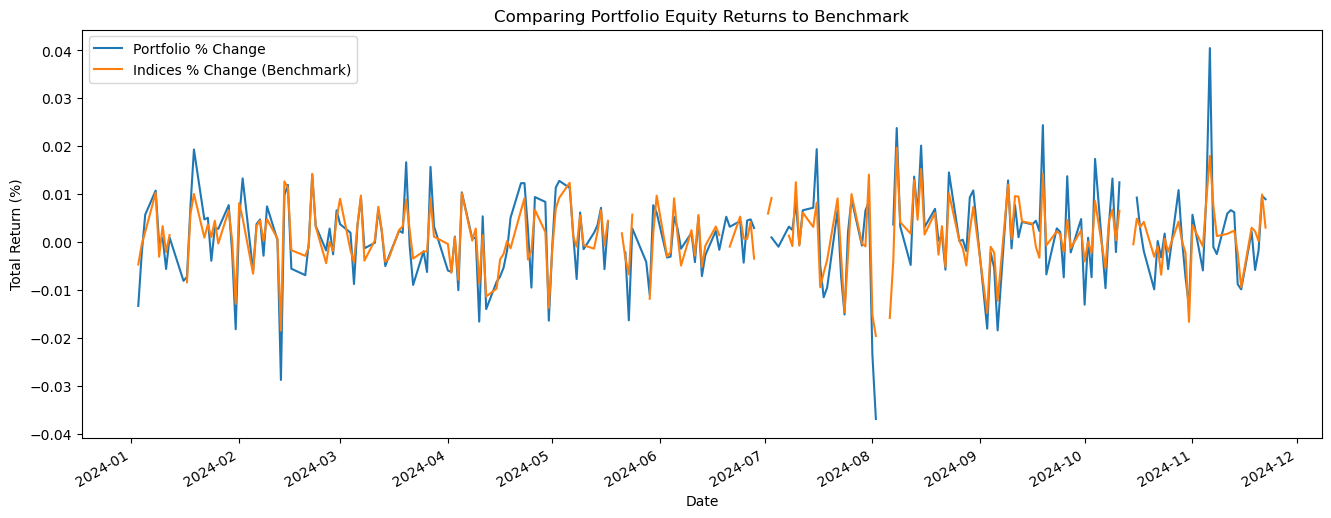

In [102]:
fig, ax = plt.subplots()
ax.set_title("Comparing Portfolio Equity Returns to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Total Return (%)")


ax.plot(comparison["Portfolio % Change"], label='Portfolio % Change')
ax.plot(comparison["Indices % Change"], label='Indices % Change (Benchmark)')
fig.autofmt_xdate()
ax.legend(loc='best')
plt.gcf().set_size_inches(16, 6)

plt.show()

As we can again see, the returns of our portfolio match the changes in the market indices fairly closely, meaning that we are meeting the market for the most part!

In [103]:
#export the final stocks and number of shares to csv file
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv('Stocks_Group_05.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:


Emily: Fetching tickers from csv and ensuring that they satisfy all filter requirements
Jonathan: Checking for upcoming earnings and dividend dates, and removing tickers if necessary
James: Calculating and sorting by total score.
